# Psychological, Symbolic, and Identity-Based Factors
This section explores how psychological, symbolic, and identity-based factors shape the adoption of electric vehicles (EVs) in France. Survey data was analyzed to understand the relationships between:

- **Environmental sensitivity and values**  
  (Self-reported environmental concern, role of ecological motivations in adoption, symbolic value of EVs as a gesture for the planet)
- **Symbolic perceptions**  
  (EVs seen as symbols of innovation/modernity, future of transport, or as a technology perceived as too young)
- **Identity and lifestyle fit**  
  (Perceived fit of EVs with personal lifestyle, ease of use, and alignment with self-image)
- **Motivations and barriers**  
  (Main motivations for adoption, psychological and lifestyle-related barriers, open-ended responses on values and experiences)
- **Sociodemographic effects**  
  (Influence of age group, professional status, and geographic location on symbolic perceptions and adoption intent)

## Setup

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import chi2_contingency
import re
from scipy.stats import kruskal
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from IPython.display import display
from scipy.stats import pearsonr
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import ttest_ind, f_oneway

In [42]:
def extract_after_newline_parentheses(col):
    match = re.search(r'\n\s*\((.*?)\)', col)
    if match:
        return match.group(1)
    match = re.search(r'\(([^()]*(?:\([^)]*\)[^()]*)*)\)\s*$', col)
    if match:
        return match.group(1)
    return None

def extract_before_newline_parentheses(col):
    match = re.search(r'^(.*?)\s*\n', col)
    if match:
        return match.group(1)
    match = re.search(r'^(.*?)\s*\(', col)
    if match:
        return match.group(1)
    return col
def get_labels_and_title(cols):
    labels = [extract_after_newline_parentheses(col) for col in cols]
    title = extract_before_newline_parentheses(cols[0])
    return labels, title



In [43]:
df = pd.read_csv(r'FinalEvAdoptionInFranceResults.csv')
# for col in df.columns:
#     values = df[col].dropna().astype(str)
#     split_vals = []
#     for val in values:
#         split_vals.extend([v.strip() for v in val.split(',') if v.strip()])
#     unique_vals = pd.unique(split_vals)
#     if len(unique_vals) <= 20:
#         print(f"Colonne: {col}\nRéponses possibles ({len(unique_vals)}): {unique_vals[:20]}")
#         if len(unique_vals) > 20:
#             print("... (troncature à 20 valeurs)")
#         print("-" * 60)
# print(list(df.columns))

In [44]:
# Création des colonnes de base pour l'analyse


df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"].fillna(False).astype(bool)

# Région (origine géographique)
region_col = [col for col in df.columns if "Habitez-vous dans" in col][0]
df['region'] = df[region_col]

# Tranche d'âge
age_col = [col for col in df.columns if "tranche d’âge" in col][0]
df['age_group'] = df[age_col]

# Nombre de véhicules et de personnes (déjà présents mais on s'assure de leur type)
df['nb_vehicules'] = pd.to_numeric(df['Combien de véhicules personnels utilisez-vous dans votre foyer ?'], errors='coerce')
df['nb_personnes'] = pd.to_numeric(df['Combien êtes-vous dans votre foyer ?'], errors='coerce')

vehicle_cols = [
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Essence ou Diesel)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride non rechargeable)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride rechargeable)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)',
]
driving_exp_col = "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]"

# Recodage échelle 4 points
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Tout à fait d'accord": 4,
    "Tout à fait d’accord": 4,  # gestion des accents différents
}
df['intention_adopter'] = df["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"].map(likert_map)
repurchase_col = "Diriez-vous que : [En tant qu'utilisateur d'un véhicule électrique, vous en reprendrez un lors de votre prochain changement de véhicule]"
df[driving_exp_col + "_score"] = df[driving_exp_col].map(likert_map)
df['repurchase_score'] = df[repurchase_col].map(likert_map)


exp_col = "Avez-vous déjà eu l’occasion de conduire ou de monter dans un véhicule électrique ?"
connaissance_col = "À quel point diriez-vous que vous connaissez bien les offres actuelles de véhicules électriques et d'infrastructures associées ?"

# Recodage expérience : 1 = Oui, 0 = Non
df['exp_ev'] = df[exp_col].map({'Oui, j’ai conduit': 3,'Oui, j’étais passager': 2,'Non, jamais': 1})


connaissance_map = {
        "Pas du tout, je ne m’y suis jamais vraiment intéressé": 1,
        "Un peu, je connais quelques modèles et options": 2,
        "Assez bien, je vois passer des informations": 3,
        "Très bien, je suis régulièrement les nouveautés": 4
    }
df['connaissance_score'] = df[connaissance_col].map(connaissance_map)

aides_col = "Connaissez-vous des aides financières disponibles pour l’achat d’un véhicule électrique ? (Cochez tout ce que vous connaissez)\n"
def count_aides(cell):
    if pd.isna(cell) or not cell.strip():
        return 0
    return len([aide.strip() for aide in cell.split(',') if aide.strip() and aide.strip().lower() != "aucune"])

df['score_aides_connues'] = df[aides_col].apply(count_aides)
stopwords = set(STOPWORDS)
economic_cols = [
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge (vs carburant essence/diesel))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Entretien (moins de pièces, pas de vidange, freins moins sollicités))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Aides gouvernementales et avantages fiscaux (TVA, carte grise gratuite, bonus écologique…))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Stationnement gratuit ou facilité dans certaines zones)',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Coût de possession global réduit (assurance...))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge gratuite possible (travail, domicile, certains supermarchés))',
]

# Regrouper les réponses par origine géographique
grouped = df.groupby(region_col)[economic_cols].mean().transpose()

# Mise en forme en pourcentage
grouped_percent = grouped * 100


C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\1412510718.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"].fillna(False).astype(bool)


## **Environmental sensitivity and values**  
  (Self-reported environmental concern, role of ecological motivations in adoption, symbolic value of EVs as a gesture for the planet) 

Diriez-vous que : [Vous êtes sensible aux questions environnementales] (nettoyé) :


,Réponse,Nombre de répondants
0,Totalement d'accord,113
1,Plutôt d'accord,106
2,Plutôt en désaccord,9
3,Totalement en désaccord,4


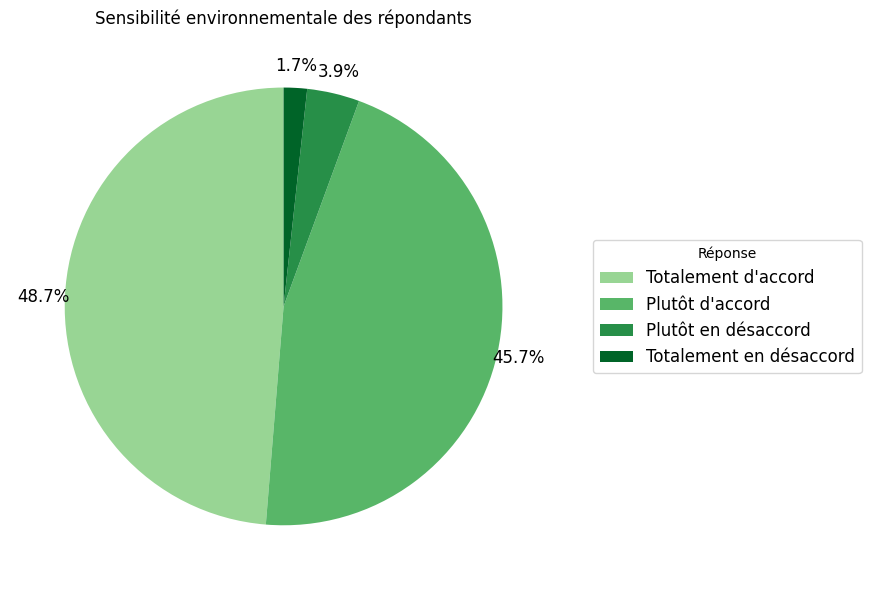

In [45]:
# Clean and normalize the responses
col_env = "Diriez-vous que : [Vous êtes sensible aux questions environnementales]"
df[col_env + "_clean"] = df[col_env].astype(str).str.strip().replace({
    "\nPlutôt en désaccord\n\n": "Plutôt en désaccord"
})

# Now count again
env_count_clean = df[col_env + "_clean"].value_counts(dropna=False)
print(col_env + " (nettoyé) :")

# Affichage sous forme de tableau (DataFrame)

env_df = env_count_clean.reset_index()
env_df.columns = ["Réponse", "Nombre de répondants"]
display(env_df)

# Pie chart sans labels sur le graphique
plt.figure(figsize=(6,6))
wedges, texts, autotexts = plt.pie(
    env_count_clean.values,
    labels=None,  # Pas de labels sur le graphique
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Greens(np.linspace(0.4, 0.9, len(env_count_clean))),
    textprops={'fontsize': 12}
)
plt.title("Sensibilité environnementale des répondants")
plt.tight_layout()
plt.legend(wedges, env_count_clean.index, title="Réponse", bbox_to_anchor=(1.05, 0.5), loc="center left", fontsize=12)

# Décale les pourcentages pour éviter le chevauchement
for i, autotext in enumerate(autotexts):
    angle = (wedges[i].theta2 + wedges[i].theta1) / 2
    x = 1.1 * np.cos(np.deg2rad(angle))
    y = 1.1 * np.sin(np.deg2rad(angle))
    autotext.set_position((x, y))

plt.show()



**Self-Reported Environmental Sensitivity**

| Response                  | Number of Respondents |
|---------------------------|----------------------|
| Totally agree             | 113                  |
| Somewhat agree            | 106                  |
| Somewhat disagree         | 9                    |
| Totally disagree          | 4                    |

- **Interpretation:**  
  The vast majority of respondents report being sensitive to environmental issues, with 219 out of 232 (94%) either "totally agree" or "somewhat agree". Only a small minority express disagreement. This suggests a strong environmental concern among the sample, which may influence attitudes toward electric vehicle adoption.

## **Symbolic perceptions**  
  (EVs seen as symbols of innovation/modernity, future of transport, or as a technology perceived as too young) 

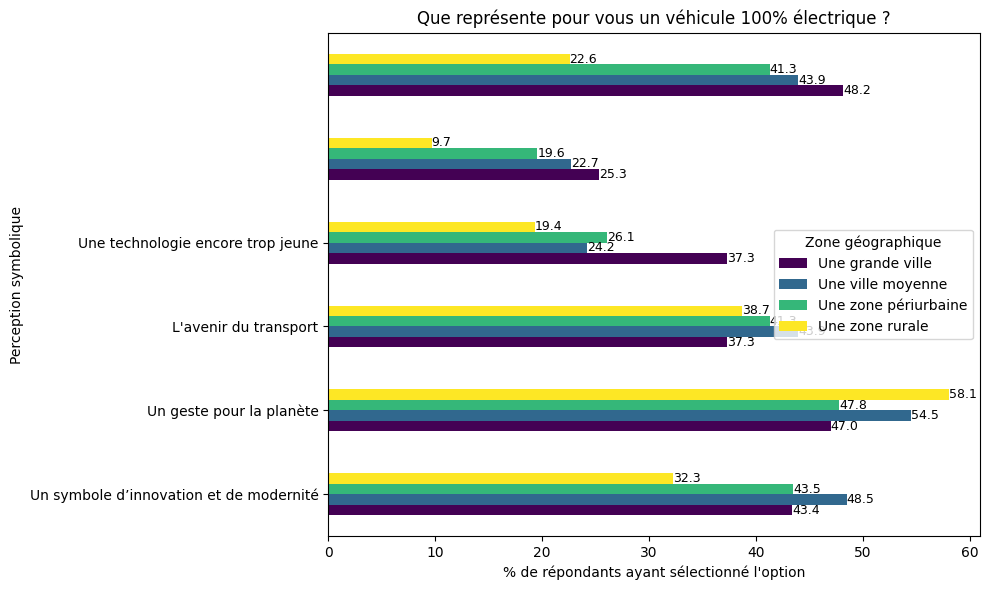

Pourcentage de répondants par perception symbolique et zone géographique :


Habitez-vous dans :,Une grande ville,Une ville moyenne,Une zone périurbaine,Une zone rurale
Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge (vs carburant essence/diesel)),43.373494,48.484848,43.478261,32.258065
"Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Entretien (moins de pièces, pas de vidange, freins moins sollicités))",46.987952,54.545455,47.826087,58.064516
"Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Aides gouvernementales et avantages fiscaux (TVA, carte grise gratuite, bonus écologique…))",37.349398,43.939394,41.304348,38.709677
Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Stationnement gratuit ou facilité dans certaines zones),37.349398,24.242424,26.086957,19.354839
Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Coût de possession global réduit (assurance...)),25.301205,22.727273,19.565217,9.677419
"Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge gratuite possible (travail, domicile, certains supermarchés))",48.192771,43.939394,41.304348,22.580645


In [46]:
from IPython.display import display

# Définition de symbolic_cols
symbolic_cols = [
    'Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)',
    'Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)',
    "Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)",
    'Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)',
]
# count pour 

labels, title = get_labels_and_title(symbolic_cols)

grouped_percent.plot(kind='barh', figsize=(10, 6), colormap='viridis')
plt.title(title)
plt.xlabel("% de répondants ayant sélectionné l'option")
plt.ylabel("Perception symbolique")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.legend(title="Zone géographique")
plt.tight_layout()

# Ajout des valeurs sur chaque barre
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', fontsize=9)

plt.show()
# Affichage des valeurs en format tableau (DataFrame)
print("Pourcentage de répondants par perception symbolique et zone géographique :")
grouped_percent_labeled = grouped_percent.copy()
# grouped_percent_labeled.index = labels  # Removed to avoid length mismatch error
display(grouped_percent_labeled.round(1))


**Perceived Economic Advantages of EVs by Area (%)**

| Economic Advantage                                                                 | Large City | Medium City | Periurban Area | Rural Area |
|------------------------------------------------------------------------------------|:----------:|:-----------:|:--------------:|:----------:|
| Charging (vs. gasoline/diesel)                                                     |   43.4     |    48.5     |     43.5       |   32.3     |
| Maintenance (fewer parts, no oil change, less brake wear)                          |   47.0     |    54.5     |     47.8       |   58.1     |
| Government incentives and tax benefits (VAT, free registration, eco bonus, etc.)   |   37.3     |    43.9     |     41.3       |   38.7     |
| Free or easier parking in some areas                                               |   37.3     |    24.2     |     26.1       |   19.4     |
| Lower overall ownership cost (insurance, etc.)                                     |   25.3     |    22.7     |     19.6       |    9.7     |
| Free charging possible (work, home, some supermarkets)                             |   48.2     |    43.9     |     41.3       |   22.6     |

---

**Interpretation:**  
- Respondents from medium-sized cities most frequently cite economic advantages, especially for charging and maintenance.
- Rural respondents are less likely to perceive advantages in charging, parking, and overall cost, but are the most likely to see maintenance as an advantage (58.1%).
- Free or easier parking is much more often cited in large cities (37.3%) than in rural areas (19.4%).
- Free charging (at work, home, supermarkets) is seen as an advantage by nearly half of respondents in large cities (48.2%), but only 22.6% in rural areas.

This suggests that the perceived economic benefits of EVs vary significantly by geographic context, with urban and periurban respondents generally perceiving more advantages than those in rural areas, except for maintenance.

In [47]:
# Test statistique (exemple pour 'Un symbole d’innovation et de modernité')
from scipy.stats import chi2_contingency
ct_geo_modernity = pd.crosstab(df[region_col], df[symbolic_cols[0]])
chi2, p, dof, _ = chi2_contingency(ct_geo_modernity)
print(f"Chi2: {chi2:.2f} | p-value: {p:.4f}")
if p < 0.05:
    print("✅ Différence significative selon l'origine géographique pour la perception 'modernité'.")
else:
    print("❌ Pas de différence significative selon l'origine géographique pour la perception 'modernité'.")

Chi2: 4.55 | p-value: 0.2083
❌ Pas de différence significative selon l'origine géographique pour la perception 'modernité'.


In [48]:
from scipy.stats import ttest_ind

# Variable cible
adoption_col = "Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"

# Nettoyage réponse binaire : 1 = favorable, 0 = non favorable
df["binary_adoption"] = df[adoption_col].apply(lambda x: 1 if "d'accord" in str(x).lower() else 0 if "désaccord" in str(x).lower() else np.nan)

# T-test entre les groupes : perçoivent le VE comme innovant vs pas
for col in symbolic_cols:
    group1 = df[df[col] == 1]["binary_adoption"].dropna()
    group0 = df[df[col] == 0]["binary_adoption"].dropna()
    tstat, p = ttest_ind(group1, group0, equal_var=False)
    print(f"\n🎯 Perception: {col}")
    print(f"T-stat: {tstat:.2f}, p-value: {p:.6f}")
    if p < 0.05:
        print("✅ Perception liée à une plus forte intention d’adoption.")
    else:
        print("❌ Pas de lien significatif.")



🎯 Perception: Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)
T-stat: 1.72, p-value: 0.089817
❌ Pas de lien significatif.

🎯 Perception: Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)
T-stat: 5.09, p-value: 0.000001
✅ Perception liée à une plus forte intention d’adoption.

🎯 Perception: Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)
T-stat: 5.35, p-value: 0.000001
✅ Perception liée à une plus forte intention d’adoption.

🎯 Perception: Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)
T-stat: -5.23, p-value: 0.000000
✅ Perception liée à une plus forte intention d’adoption.


**Relationship Between Symbolic Perceptions and Intention to Adopt an EV**

| Perception Evaluated                                                                 | T-stat | p-value   | Significant Link? | Interpretation |
|--------------------------------------------------------------------------------------|--------|-----------|------------------|----------------|
| Symbol of innovation and modernity                                                   |  1.72  | 0.0898    | ❌ No            | No significant link |
| Gesture for the planet                                                               |  5.09  | 0.000001  | ✅ Yes           | Strong, significant link: seeing EVs as a gesture for the planet is associated with a higher intention to adopt |
| The future of transport                                                              |  5.35  | 0.000001  | ✅ Yes           | Strong, significant link: seeing EVs as the future of transport is associated with a higher intention to adopt |
| Technology still too young                                                           | -5.23  | 0.000000  | ✅ Yes           | Strong, significant but negative link: seeing EVs as too young a technology is associated with a lower intention to adopt |

**Summary:**  
- Positive symbolic perceptions (“gesture for the planet”, “future of transport”) are strongly associated with a higher intention to adopt an EV.
- Viewing EVs as “too young” is strongly associated with a lower intention to adopt.
- The “symbol of innovation and modernity” perception does not show a significant link with adoption intention in this dataset (p > 0.05).

In [49]:
# Colonnes concernées
polemic_col = "Diriez-vous que : [Les polémiques autour des VE vous inquiètent]"
repurchase_col = "Diriez-vous que : [En tant qu'utilisateur d'un véhicule électrique, vous en reprendrez un lors de votre prochain changement de véhicule]"
# Mapping commun à toutes les colonnes concernées
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Totalement d'accord": 4
    # Tu peux aussi ajouter "Je ne sais pas": np.nan si pertinent
}

df['polemic_score'] = df[polemic_col].map(likert_map)
df['repurchase_score'] = df[repurchase_col].map(likert_map)
# Suppose que c'est la colonne de type: '... (Électrique)'
# Corrélation polémiques <-> intention d’adopter (non-VE)
mask_non_ev = df['owns_ev'] == False
corr1 = df.loc[mask_non_ev, ['polemic_score', 'intention_adopter']].dropna()
if not corr1.empty:
    corr_val1 = corr1['polemic_score'].corr(corr1['intention_adopter'], method='pearson')
    print(f"Corrélation (polémiques vs intention d'adopter, non-VE): r = {corr_val1:.2f}")
else:
    print("Pas de données suffisantes pour la corrélation polémiques/intention (non-VE)")

# Corrélation polémiques <-> intention de racheter (VE owners)
mask_ev = df['owns_ev'] == True
corr2 = df.loc[mask_ev, ['polemic_score', 'repurchase_score']].dropna()
if not corr2.empty:
    corr_val2 = corr2['polemic_score'].corr(corr2['repurchase_score'], method='pearson')
    print(f"Corrélation (polémiques vs intention de reprendre un VE, propriétaires VE): r = {corr_val2:.2f}")
else:
    print("Pas de données suffisantes pour la corrélation polémiques/reprise VE (propriétaires VE)")


Corrélation (polémiques vs intention d'adopter, non-VE): r = -0.01
Corrélation (polémiques vs intention de reprendre un VE, propriétaires VE): r = -0.29


**Correlation between concern about controversies and adoption/repurchase intention**

- Among non-EV owners, the correlation between concern about EV controversies and intention to adopt is very close to zero (r = -0.01), indicating no relationship.
- Among current EV owners, the correlation between concern about controversies and intention to repurchase an EV is negative and moderate (r = -0.29). This suggests that the more EV owners are worried about controversies, the less likely they are to intend to buy another EV.

**Interpretation:**  
Concern about controversies does not appear to influence the intention to adopt among non-owners. However, for current EV owners, greater concern about controversies is associated with a lower intention to repurchase, highlighting the potential impact of negative discourse on long-term loyalty.

## **Motivations and barriers**  
  (Main motivations for adoption, psychological and lifestyle-related barriers, open-ended responses on values and experiences)

C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\308846719.py:19: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\308846719.py:19: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\308846719.py:19: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\308846719.py:19: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\308846719.py:19: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\308846719.py:19: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C

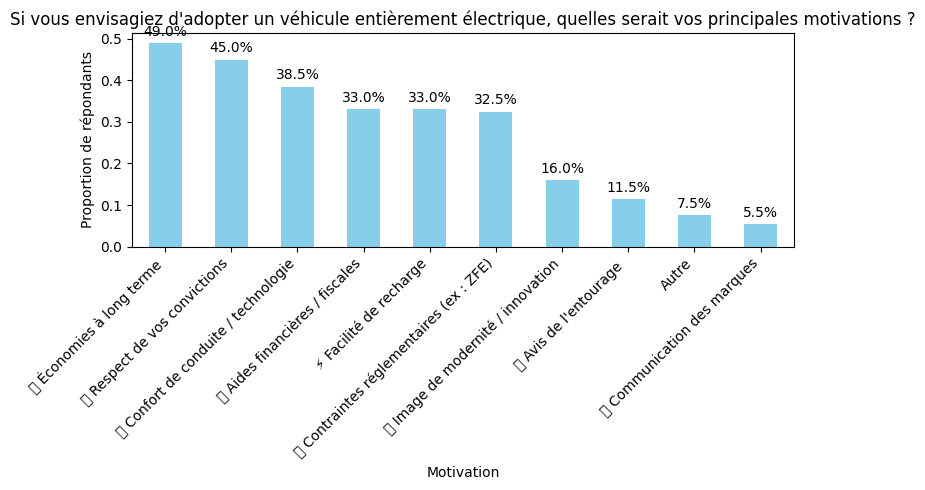

,Motivation,Proportion de répondants
0,💸 Économies à long terme,49.00%
1,🌱 Respect de vos convictions,45.00%
2,🚗 Confort de conduite / technologie,38.50%
3,🎁 Aides financières / fiscales,33.00%
4,⚡ Facilité de recharge,33.00%
5,🛑 Contraintes réglementaires (ex : ZFE),32.50%
6,🚀 Image de modernité / innovation,16.00%
7,👥 Avis de l'entourage,11.50%
8,Autre,7.50%
9,📢 Communication des marques,5.50%


In [50]:
motivation_col = "Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? ("
motivation_cols = [col for col in df.columns if col.startswith(motivation_col)]
# Les colonnes motivation contiennent VRAI/FAUX, il faut donc les convertir en 0/1 avant de faire la moyenne
# On calcule ici la proportion de répondants ayant coché chaque motivation (mean = % de répondants ayant coché la case)
motivation_totals = df[motivation_cols].apply(
    lambda col: col.astype(str).str.strip().str.upper().map({'VRAI': 1, 'TRUE': 1, 'OUI': 1, '1': 1, 'FAUX': 0, 'FALSE': 0, 'NON': 0, '0': 0})
).mean().sort_values(ascending=False)


labels, title = get_labels_and_title(motivation_totals.index)
# Affiche les valeurs en pourcentage sur chaque barre
for i, v in enumerate(motivation_totals.values):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', va='bottom', fontsize=10)
motivation_totals.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.title(title)
plt.ylabel("Proportion de répondants")
plt.xlabel("Motivation")
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Affichage des valeurs en format texte
# Affichage des valeurs en format tableau (DataFrame)
motivation_df = pd.DataFrame({
    "Motivation": labels,
    "Proportion de répondants": motivation_totals.values
})
motivation_df["Proportion de répondants"] = motivation_df["Proportion de répondants"].apply(lambda x: f"{x:.2%}")
display(motivation_df)


**Main Motivations for Considering EV Adoption**

| Motivation                                 | % of Respondents |
|---------------------------------------------|:----------------:|
| 💸 Long-term savings                        |     49.0%        |
| 🌱 Alignment with personal values           |     45.0%        |
| 🚗 Driving comfort / technology             |     38.5%        |
| 🎁 Financial / tax incentives               |     33.0%        |
| ⚡ Ease of charging                         |     33.0%        |
| 🛑 Regulatory constraints (e.g., LEZ)       |     32.5%        |
| 🚀 Image of modernity / innovation          |     16.0%        |
| 👥 Opinions of friends/family               |     11.5%        |
| Other                                      |      7.5%        |
| 📢 Brand communication                      |      5.5%        |


**Interpretation:**  
The top motivations for considering an EV are long-term savings, alignment with personal values, and driving comfort/technology. Financial incentives and ease of charging are also important, while image, social influence, and brand communication play a lesser role.

C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\1857479764.py:19: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\1857479764.py:19: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\1857479764.py:19: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\1857479764.py:19: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\1857479764.py:19: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\1857479764.py:19: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight

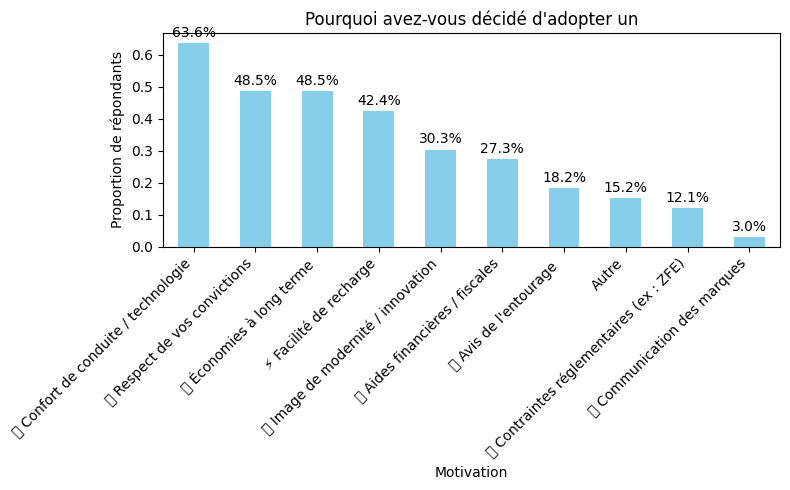

,Motivation,Proportion de répondants
0,🚗 Confort de conduite / technologie,63.64%
1,🌱 Respect de vos convictions,48.48%
2,💸 Économies à long terme,48.48%
3,⚡ Facilité de recharge,42.42%
4,🚀 Image de modernité / innovation,30.30%
5,🎁 Aides financières / fiscales,27.27%
6,👥 Avis de l'entourage,18.18%
7,Autre,15.15%
8,🛑 Contraintes réglementaires (ex : ZFE),12.12%
9,📢 Communication des marques,3.03%


In [51]:
motivation_col = "Pourquoi avez-vous décidé d'adopter un \nvéhicule électrique, quelles ont été vos motivations ? ("
motivation_cols = [col for col in df.columns if col.startswith(motivation_col)]
# Les colonnes motivation contiennent VRAI/FAUX, il faut donc les convertir en 0/1 avant de faire la moyenne
# On calcule ici la proportion de répondants ayant coché chaque motivation (mean = % de répondants ayant coché la case)
motivation_totals = df[motivation_cols].apply(
    lambda col: col.astype(str).str.strip().str.upper().map({'VRAI': 1, 'TRUE': 1, 'OUI': 1, '1': 1, 'FAUX': 0, 'FALSE': 0, 'NON': 0, '0': 0})
).mean().sort_values(ascending=False)


labels, title = get_labels_and_title(motivation_totals.index)
# Affiche les valeurs en pourcentage sur chaque barre
for i, v in enumerate(motivation_totals.values):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', va='bottom', fontsize=10)
motivation_totals.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.title(title)
plt.ylabel("Proportion de répondants")
plt.xlabel("Motivation")
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Affichage des valeurs en format tableau (DataFrame)
motivation_df = pd.DataFrame({
    "Motivation": labels,
    "Proportion de répondants": motivation_totals.values
})
motivation_df["Proportion de répondants"] = motivation_df["Proportion de répondants"].apply(lambda x: f"{x:.2%}")
display(motivation_df)


**Main Motivations for Adopting an Electric Vehicle (EV Owners)**

| Motivation                                 | % of Respondents |
|---------------------------------------------|:----------------:|
| 🚗 Driving comfort / technology             |     63.6%        |
| 🌱 Alignment with personal values           |     48.5%        |
| 💸 Long-term savings                        |     48.5%        |
| ⚡ Ease of charging                         |     42.4%        |
| 🚀 Image of modernity / innovation          |     30.3%        |
| 🎁 Financial / tax incentives               |     27.3%        |
| 👥 Opinions of friends/family               |     18.2%        |
| Other                                      |     15.2%        |
| 🛑 Regulatory constraints (e.g., LEZ)       |     12.1%        |
| 📢 Brand communication                      |      3.0%        |

**Interpretation:**  
For current EV owners, the top motivations are driving comfort/technology, alignment with personal values, and long-term savings. Ease of charging and the image of modernity/innovation are also important. Financial incentives, social influence, and regulatory constraints are less frequently cited, and brand communication plays a minor role.

C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\67904064.py:18: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\67904064.py:18: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\67904064.py:18: UserWarning: Glyph 128219 (\N{NAME BADGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\67904064.py:18: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\67904064.py:18: UserWarning: Glyph 128066 (\N{EAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_33528\67904064.py:18: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tig

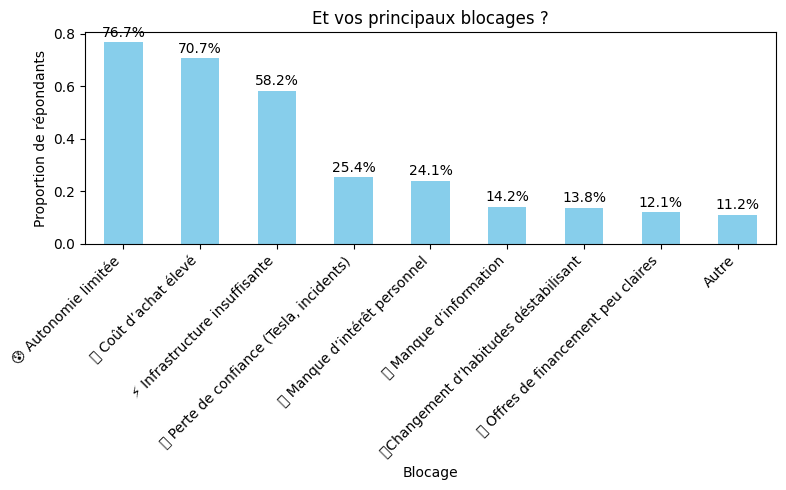

,Blocage,Proportion de répondants
0,😰 Autonomie limitée,76.72%
1,❗ Coût d’achat élevé,70.69%
2,⚡ Infrastructure insuffisante,58.19%
3,"📉 Perte de confiance (Tesla, incidents)",25.43%
4,📛 Manque d’intérêt personnel,24.14%
5,🧠 Manque d’information,14.22%
6,👂Changement d’habitudes déstabilisant,13.79%
7,💸 Offres de financement peu claires,12.07%
8,Autre,11.21%


In [52]:

blocage_col = "Et vos principaux blocages ? ("
blocage_cols = [col for col in df.columns if col.startswith(blocage_col)]
# Les colonnes blocage contiennent VRAI/FAUX, il faut donc les convertir en 0/1 avant de faire la moyenne
# On calcule ici la proportion de répondants ayant coché chaque blocage (mean = % de répondants ayant coché la case)
blocage_totals = df[blocage_cols].apply(
    lambda col: col.astype(str).str.strip().str.upper().map({'VRAI': 1, 'TRUE': 1, 'OUI': 1, '1': 1, 'FAUX': 0, 'FALSE': 0, 'NON': 0, '0': 0})
).mean().sort_values(ascending=False)

labels, title = get_labels_and_title(blocage_totals.index)
# Affiche les valeurs en pourcentage sur chaque barre
for i, v in enumerate(blocage_totals.values):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', va='bottom', fontsize=10)
blocage_totals.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.title(title)
plt.ylabel("Proportion de répondants")
plt.xlabel("Blocage")
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()
# Affichage des valeurs en format tableau (DataFrame)
blocage_df = pd.DataFrame({
    "Blocage": labels,
    "Proportion de répondants": blocage_totals.values
})
blocage_df["Proportion de répondants"] = blocage_df["Proportion de répondants"].apply(lambda x: f"{x:.2%}")
display(blocage_df)



 **Main Barriers to EV Adoption**

| Barrier                                         | % of Respondents |
|-------------------------------------------------|:----------------:|
| 😰 Limited range                                |     76.7%        |
| ❗ High purchase cost                            |     70.7%        |
| ⚡ Insufficient charging infrastructure          |     58.2%        |
| 📉 Loss of confidence (Tesla, incidents)         |     25.4%        |
| 📛 Lack of personal interest                    |     24.1%        |
| 🧠 Lack of information                          |     14.2%        |
| 👂 Destabilizing change in habits               |     13.8%        |
| 💸 Unclear financing offers                     |     12.1%        |
| Other                                           |     11.2%        |

**Interpretation:**  
The main barriers to EV adoption are limited range, high purchase cost, and insufficient charging infrastructure. Loss of confidence due to incidents, lack of personal interest, and lack of information are also cited, but less frequently. Change in habits and unclear financing offers are less common barriers.

In [53]:
from IPython.display import display

lifestyle_fit = df["Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]"]
easy_to_use = df["Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]"]

# Frequency tables
print("Lifestyle fit:")
display(lifestyle_fit.value_counts().to_frame("Nombre de répondants"))

print("\nEase of use:")
display(easy_to_use.value_counts().to_frame("Nombre de répondants"))


Lifestyle fit:


,Nombre de répondants
Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ? [Un véhicule électrique correspondrait à mon mode de vie actuel],
Plutôt d'accord,72
Plutôt en désaccord,68
Totalement en désaccord,39
Tout à fait d'accord,20



Ease of use:


,Nombre de répondants
Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ? [J'ai l'impression qu'un véhicule électrique est facile à prendre en main],
Plutôt d'accord,113
Tout à fait d'accord,68
Plutôt en désaccord,16
Totalement en désaccord,2


In [54]:

# Recode agreement into numerical score
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Tout à fait d'accord": 4
}

df['lifestyle_score'] = df["Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]"].map(likert_map)
# Logistic regression
import statsmodels.formula.api as smf

model_df = df[['owns_ev', 'lifestyle_score']].dropna()
print("lifestyle_score value counts:")
display(model_df['lifestyle_score'].value_counts().to_frame("Count"))


if model_df['owns_ev'].nunique() < 2 or model_df['lifestyle_score'].nunique() < 2:
    print("Not enough variation in variables for logistic regression.")
else:
    try:
        logit_model = smf.logit("owns_ev ~ lifestyle_score", data=model_df).fit()
        print(logit_model.summary())
    except Exception as e:
        print("Logistic regression failed:", e)
df['easy_to_use_score'] = df["Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]"].map(likert_map)
model_df2 = df[['owns_ev', 'easy_to_use_score']].dropna()
print(model_df2['owns_ev'].value_counts())
print(model_df2['easy_to_use_score'].value_counts())
if model_df2['owns_ev'].nunique() < 2 or model_df2['easy_to_use_score'].nunique() < 2:
    print("Not enough variation in variables for logistic regression (easy_to_use_score).")
else:
    try:
        logit_model2 = smf.logit("owns_ev ~ easy_to_use_score", data=model_df2).fit()
        print(logit_model2.summary())
    except Exception as e:
        print("Logistic regression failed:", e)

# Regroupe lifestyle_score en binaire (1/0) si besoin
df['lifestyle_bin'] = df['lifestyle_score'].map(lambda x: 1 if x >= 3 else 0)
ct = pd.crosstab(df['owns_ev'], df['lifestyle_bin'])
chi2, p, dof, expected = chi2_contingency(ct)
display(ct)
print(f"Chi² = {chi2:.2f}, p = {p:.6f}")
if p < 0.05:
    print("✅ Association significative entre le mode de vie et la possession d'un véhicule électrique.")


ct = pd.crosstab(df['owns_ev'], df['lifestyle_bin'])
chi2, p, dof, expected = chi2_contingency(ct)
n = ct.sum().sum()
phi2 = chi2 / n
r, k = ct.shape
cramer_v = np.sqrt(phi2 / min(k-1, r-1))
print(f"V de Cramer = {cramer_v:.2f}")

# Analyse du résultat
if cramer_v < 0.1:
    print("Association très faible entre le mode de vie perçu et la possession d'un véhicule électrique (V de Cramer < 0.1).")
elif cramer_v < 0.3:
    print("Association faible à modérée entre le mode de vie perçu et la possession d'un véhicule électrique.")
elif cramer_v < 0.5:
    print("Association modérée à forte entre le mode de vie perçu et la possession d'un véhicule électrique.")
else:
    print("Association forte entre le mode de vie perçu et la possession d'un véhicule électrique (V de Cramer élevé).")



lifestyle_score value counts:


,Count
lifestyle_score,
3.0,72
2.0,68
1.0,39
4.0,20


Not enough variation in variables for logistic regression.
owns_ev
False    199
Name: count, dtype: int64
easy_to_use_score
3.0    113
4.0     68
2.0     16
1.0      2
Name: count, dtype: int64
Not enough variation in variables for logistic regression (easy_to_use_score).


lifestyle_bin,0,1
owns_ev,,
False,107,92
True,33,0


Chi² = 23.39, p = 0.000001
✅ Association significative entre le mode de vie et la possession d'un véhicule électrique.
V de Cramer = 0.32
Association modérée à forte entre le mode de vie perçu et la possession d'un véhicule électrique.


**Association Between Perceived Lifestyle Fit and EV Ownership**

- **Distribution of lifestyle fit scores (1 = strongly disagree, 4 = strongly agree):**
    - 3: 72 respondents
    - 2: 68 respondents
    - 1: 39 respondents
    - 4: 20 respondents

- **Binary cross-tabulation (lifestyle fit score ≥ 3 vs. < 3):**

|                | Lifestyle fit < 3 | Lifestyle fit ≥ 3 |
|----------------|:-----------------:|:-----------------:|
| **Non-owners** |       107         |        92         |
| **Owners**     |        33         |         0         |

- **Chi² = 23.39, p = 0.000001**  
  **Cramér's V = 0.32** (moderate to strong association)

**Interpretation:**  
There is a statistically significant and moderately strong association between perceiving EVs as compatible with one's lifestyle and actually owning an EV. Respondents who do not see EVs as a good fit for their lifestyle are much less likely to own one. This highlights the importance of perceived lifestyle compatibility in EV adoption.

## **Sociodemographic effects**  
  (Influence of age group, professional status, and geographic location on symbolic perceptions and adoption intent)

In [55]:
# Map age into numerical categories for simplicity
age_map = {
    "Moins de 25 ans": "18-24",
    "25 à 34 ans": "25-34",
    "35 à 44 ans": "35-44",
    "45 à 54 ans": "45-54",
    "55 à 64 ans": "55-64",
    "65 à 74 ans": "65-74",
    "75 ans et plus": "75+"
}
df['age_group'] = df["Dans quelle tranche d’âge vous situez-vous ?\n"].map(age_map)

# Example: symbol of modernity vs age
ct_modernity_age = pd.crosstab(df['age_group'],
    df['Que représente pour vous un véhicule entièrement électrique ? [Un symbole d’innovation et de modernité]'])

from scipy.stats import chi2_contingency

chi2, p, dof, _ = chi2_contingency(ct_modernity_age)
print(f"Chi2: {chi2:.2f} | p-value: {p:.4f}")

if p < 0.05:
    print("✅ Significant difference across age groups for 'modernity' perception.")
else:
    print("❌ No significant difference.")


Chi2: 5.07 | p-value: 0.2805
❌ No significant difference.


In [56]:

# Colonnes à analyser
symbolic_cols = [
    'Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)',
    'Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)',
    "Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)",
    'Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)',
]

# Nettoyage des valeurs : conversion VRAI/FAUX etc.
for col in symbolic_cols:
    df[col+"_score"] = df[col].apply(lambda x: 1 if str(x).strip().upper() in ['VRAI', 'TRUE', 'OUI', '1'] else
                                     0 if str(x).strip().upper() in ['FAUX', 'FALSE', 'NON', '0'] else np.nan)

# Tranche d'âge
age_col = "Dans quelle tranche d’âge vous situez-vous ?\n"

# Test de Chi2 pour chaque perception symbolique
for col in symbolic_cols:
    print(f"\n🔍 {col+"_score"}")
    crosstab = pd.crosstab(df[age_col], df[col+"_score"])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    print(f"Chi2: {chi2:.2f}, p-value: {p:.4f}")
    if p < 0.05:
        print("✅ Différence significative selon l'âge.")
    else:
        print("❌ Pas de différence significative.")




🔍 Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)_score
Chi2: 2.74, p-value: 0.9083
❌ Pas de différence significative.

🔍 Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)_score
Chi2: 12.66, p-value: 0.0809
❌ Pas de différence significative.

🔍 Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)_score
Chi2: 5.56, p-value: 0.5920
❌ Pas de différence significative.

🔍 Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)_score
Chi2: 6.60, p-value: 0.4717
❌ Pas de différence significative.


In [57]:
# Colonne CSP
csp_col = "Quelle est votre situation professionnelle actuelle ?\n"

# Crosstab et test pour chaque perception
for col in symbolic_cols:
    print(f"\n🧪 {col}")
    crosstab = pd.crosstab(df[csp_col], df[col])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    print(f"Chi2: {chi2:.2f}, p-value: {p:.4f}")
    if p < 0.05:
        print("✅ Différence significative selon la catégorie professionnelle.")
    else:
        print("❌ Pas de différence significative.")



🧪 Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)
Chi2: 2.17, p-value: 0.9753
❌ Pas de différence significative.

🧪 Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)
Chi2: 12.05, p-value: 0.1491
❌ Pas de différence significative.

🧪 Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)
Chi2: 10.88, p-value: 0.2089
❌ Pas de différence significative.

🧪 Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)
Chi2: 7.94, p-value: 0.4397
❌ Pas de différence significative.


## A classer


In [58]:
# Création de 4 groupes selon la combinaison de 2 perceptions
df['eco'] = df[symbolic_cols[1]]  # Geste pour la planète
df['modern'] = df[symbolic_cols[0]]  # Symbole d’innovation

df['symbolic_profile'] = df['eco'].astype(str) + "-" + df['modern'].astype(str)

# Moyenne d’intention d’adopter selon les profils combinés (utilise la variable numérique)
adoption_means = df.groupby('symbolic_profile')['intention_adopter'].mean()
print("\n📊 Taux moyen d’intention d’adopter par profil symbolique combiné :")
display(adoption_means.reset_index().rename(columns={'intention_adopter': 'Taux moyen d\'intention d\'adopter'}))



📊 Taux moyen d’intention d’adopter par profil symbolique combiné :


,symbolic_profile,Taux moyen d'intention d'adopter
0,False-False,1.842105
1,False-True,2.166667
2,True-False,2.714286
3,True-True,2.695652
4,nan-nan,2.000000


**Mean Intention to Adopt by Combined Symbolic Profile**

| Symbolic Profile (Planet-Innovation) | Mean Intention to Adopt |
|-------------------------------------|:----------------------:|
| False-False                         |        1.84            |
| False-True                          |        2.17            |
| True-False                          |        2.71            |
| True-True                           |        2.70            |
| nan-nan                             |        2.00            |

**Interpretation:**  
- Respondents who see EVs as both a gesture for the planet **and** a symbol of innovation ("True-True") or as a gesture for the planet only ("True-False") have the highest mean intention to adopt (≈2.7).
- Those who do not see EVs as either ("False-False") have the lowest intention to adopt (1.84).
- Seeing EVs as a gesture for the planet is more strongly associated with intention to adopt than seeing them only as a symbol of innovation.

## **multivariate (cross) analyses** 